In [4]:
import xarray as xr
import numpy as np
import sys
import pandas as pd
# matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mpl_c
from tqdm import tqdm, trange
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import dask
import os    

In [6]:
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
import preprocessing_modules
from preprocessing_modules import find_nearest_pixelcoods

### Level 1.5 MSG SEVIRI data prep for testmonth

In [4]:
ds_seviri = xr.open_zarr('/pd/data/CML/seviri/test_wiegels/DE_06.zarr', chunks=None)

In [ ]:
ds_seviri.IR_108.isel(time=11260).plot(x='LON', y='LAT')

### DWD Regclim data preparation for testmonth

In [5]:
ds_yw = xr.open_dataset('data/ds_yw_202006')

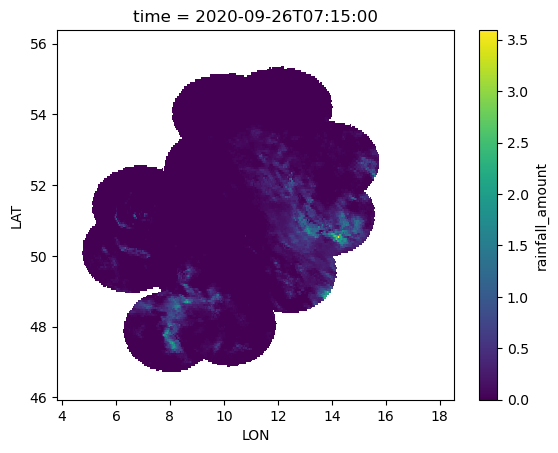

In [8]:
ds_yw.rainfall_amount.isel(time=11260).plot(x='LON', y='LAT')

# Preprocessing

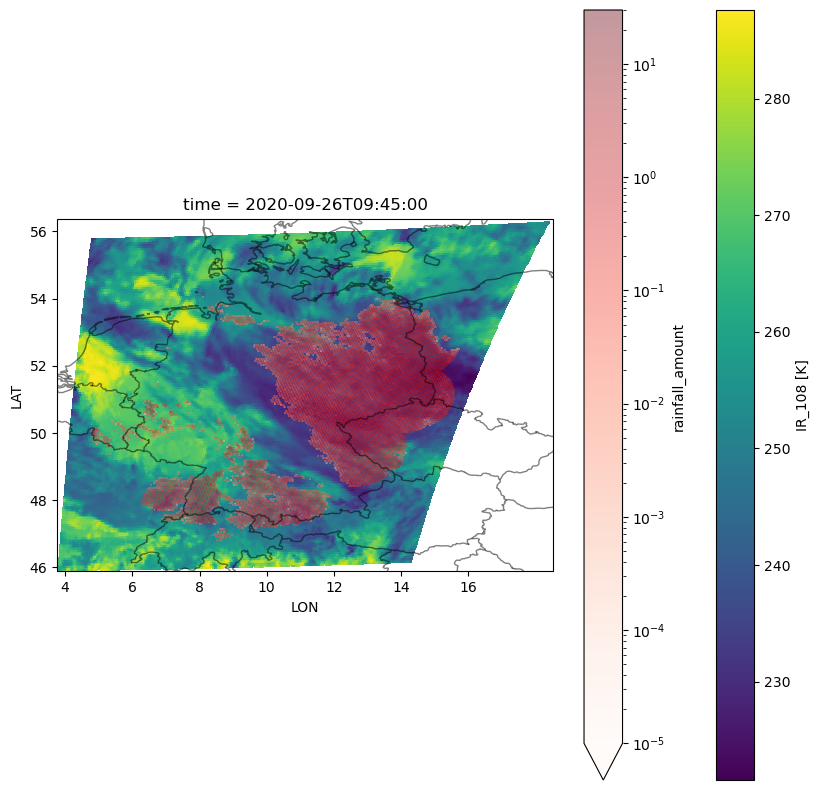

In [9]:
# plot both on map
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cmap = 'YlGnBu'
vmax = 30
extent = [3, 18, 45, 56]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
ax.add_feature(cfeature.BORDERS, alpha=0.5)

xticks = np.arange(2, 18, 2)
yticks = np.arange(46, 58, 2)
ax.set_xticks(xticks)
ax.set_yticks(yticks)



ds_seviri.IR_108.isel(time=11270).plot(
    x='LON', 
    y='LAT',


)

ds_yw.rainfall_amount.isel(time=11270).plot(
    x='LON',
    y='LAT',
    transform=ccrs.PlateCarree(),

    norm=mpl_c.LogNorm(vmin=0.00001, vmax=30), 
    cmap='Reds',
    alpha=0.4
)

plt.show()

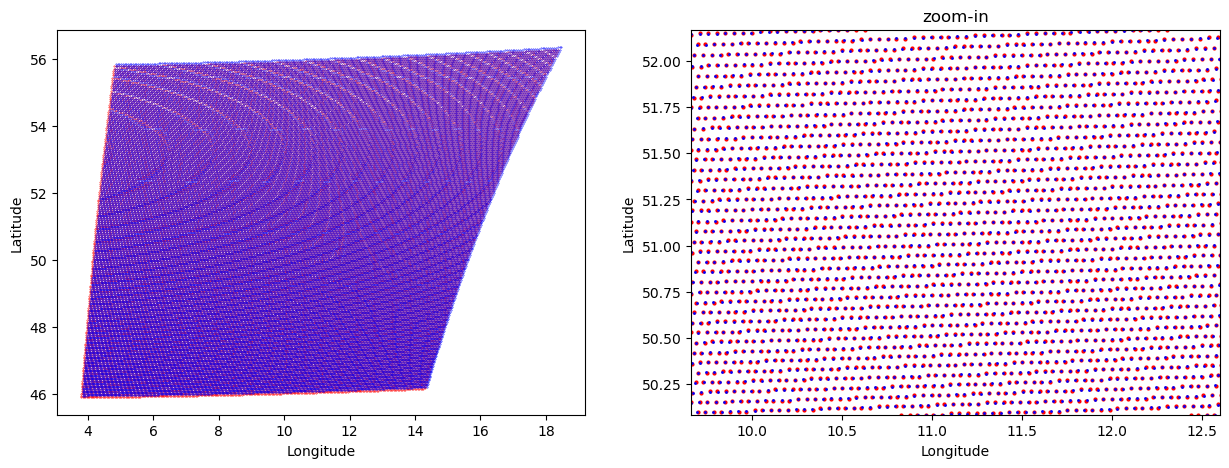

In [11]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(ds_seviri.LON.values, ds_seviri.LAT.values, s=0.1, c='r')
ax1.scatter(ds_yw.LON.values, ds_yw.LAT.values, s=0.1, c='b')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax2 = plt.subplot(1, 2, 2)#
ax2.scatter(ds_seviri.LON.values, ds_seviri.LAT.values, s=4, c='r')
ax2.scatter(ds_yw.LON.values, ds_yw.LAT.values, s=1, c='b')
ax2.margins(-0.4)
ax2.set_title('zoom-in')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.show()

# Creating data samples

In [12]:
# test if time period and time steps completly overlap
pd_yw = pd.Index(ds_yw.time.values)
pd_seviri = pd.Index(ds_seviri.time.values)

pd_yw.difference(pd_seviri).values

array([], dtype='datetime64[ns]')

## Extract patches

In [7]:
def create_patch_dataset(ds_input, ds_target, i, patch_size=(9, 9)):
    '''
    create patches out  of two datasets for a certain timestep i
    '''
     # create numpy array with needed channels in correct shape
    sev_array = np.asarray([np.asarray(ds_input.isel(time=i).IR_016), 
                            np.asarray(ds_input.isel(time=i).IR_039),
                            np.asarray(ds_input.isel(time=i).IR_087),
                            np.asarray(ds_input.isel(time=i).IR_108),
                            np.asarray(ds_input.isel(time=i).IR_120),
                            np.asarray(ds_input.isel(time=i).VIS006),
                            np.asarray(ds_input.isel(time=i).WV_062),
                            np.asarray(ds_input.isel(time=i).WV_073),
                            np.asarray(ds_input.LAT),         
                            np.asarray(ds_input.LON)
                           ])
    sev_arr = np.transpose(sev_array, [1, 2, 0])
    #print('check same timestep', ds_input.time.isel(time=i), ds_target.time.isel(time=i))
    max_patches = (ds_input.y.size * ds_input.x.size) / (patch_size[0]*patch_size[1])
    # extract patches of input dataset
    patches = image.extract_patches_2d(sev_arr, patch_size, max_patches=int(max_patches))
    
    # initialize input and target lists
    target_patches = []
    input_patches = []
    ds_list = []
    for p in range (0, patches.shape[0]):
        # define corners of patch
        ll_lon, ll_lat = patches[p, 0, 0, 9], patches[p, 0, 0, 8]
        ur_lon, ur_lat = patches[p, patch_size[0]-1, patch_size[0]-1, 9], patches[p, patch_size[0]-1, patch_size[0]-1, 8]

        lr_lon, lr_lat = patches[p, 0, patch_size[0]-1, 9], patches[p, 0, patch_size[0]-1, 8]
        ul_lon, ul_lat = patches[p, patch_size[0]-1, 0, 9], patches[p, patch_size[0]-1, 0, 8]
        #print('ll', ll_lon, ll_lat, 'ur', ur_lon, ur_lat, 'lr', lr_lon, lr_lat, 'ul', ul_lon, ul_lat)
        
        #get pixel coordinates of corners
        ([ur_yloc], [ur_xloc]) = find_nearest_pixelcoods(ur_lat, ur_lon, ds_target.LAT, ds_target.LON)
        ([ll_yloc], [ll_xloc]) = find_nearest_pixelcoods(ll_lat, ll_lon, ds_target.LAT, ds_target.LON)
        ([lr_yloc], [lr_xloc]) = find_nearest_pixelcoods(lr_lat, lr_lon, ds_target.LAT, ds_target.LON)
        ([ul_yloc], [ul_xloc]) = find_nearest_pixelcoods(ul_lat, ul_lon, ds_target.LAT, ds_target.LON)


        # cut of RADKLIM to target_patch
        # Check if patch size same to input patch size, else correct
        if not (ur_xloc-ll_xloc)==patch_size[1]:
            if (ur_xloc-ll_xloc)<patch_size[1]:
                ur_xloc = ur_xloc + 1
            if (ur_xloc-ll_xloc)>patch_size[1]:
                ur_xloc = ur_xloc - 1
        if not (ur_yloc-ll_yloc)==patch_size[0]:
            if (ur_yloc-ll_yloc)<patch_size[0]:
                ur_yloc = ur_yloc + 1
            if (ur_yloc-ll_yloc)>patch_size[0]:
                ur_yloc = ur_yloc - 1
        target_values = ds_target.rainfall_amount.isel(time=i).sel(x=slice(ll_xloc, ur_xloc), y=slice(ll_yloc, ur_yloc)) # adapt: loc=same as of seviri patch
        target_patch = np.asarray(target_values.values)
        #target_patch = np.asarray([target_values.values, target_values.LAT.values, target_values.LON.values])
        #target_patch = np.transpose(target_patch, [1, 2, 0]) # shape:(patches, y, x)

        # if target patch includes no NaNs the patches can be appended
        target_null = np.isnan(target_patch)
        if np.count_nonzero(target_null)==0:
            timestep = np.datetime_as_string(ds_input.time.isel(time=i).values)
            ds_patches = xr.Dataset(
                data_vars={
                        'input':(['ID', 'y1', 'x1', 'channels'], patches[p, :, :, :8].reshape(1, patches[p, :, :, :8].shape[0], patches[p, :, :, :8].shape[1], patches[p, :, :, :8].shape[2])),
                        'target': (['ID', 'y2', 'x2', 'rainfall'], target_patch.reshape(1, target_patch.shape[0], target_patch.shape[1], 1)),
                    #'target':(['ID', 'y2', 'x2', 'rainfall'], target_patch[:, :, 0].reshape(1, target_patch[:, :, 0].shape[0], target_patch[:, :, 0].shape[1], 1)),
                        'times': (['ID', 'time'], ds_input.time.isel(time=i).data.reshape(1, 1))
                         },
                coords={
                    'lat_low': (['ID', 'y1', 'x1'], patches[p, :, :, 8].reshape(1, patches[p, :, :, 8].shape[0], patches[p, :, :, 8].shape[1])),
                    'lon_low': (['ID', 'y1', 'x1'], patches[p, :, :, 9].reshape(1, patches[p, :, :, 9].shape[0], patches[p, :, :, 9].shape[1])),
                    'lat_high': (['ID', 'y2', 'x2'], target_values.LAT.values.reshape(1, target_values.LAT.values.shape[0], target_values.LAT.values.shape[1])),
                    'lon_high': (['ID', 'y2', 'x2'], target_values.LON.values.reshape(1, target_values.LON.values.shape[0], target_values.LON.values.shape[1]))
                }
                )

            ds_list.append(ds_patches)
                

        else:
            continue
            #print(np.asarray(target_patches).shape)
    #target_patches = np.asarray(target_patches)
    #input_patches = np.asarray(input_patches)
    if len(ds_list)==0: 
        ds_patches = np.nan
    else:
        ds_patches = xr.concat(ds_list, dim='ID')
    #patches = [target_patches, input_patches]
    return ds_patches

In [46]:
# Check out large patches to check if patch creation input and target overlaps correctly!
timestep = 11270
test = create_patch_dataset(ds_seviri, ds_yw, timestep, patch_size=(30,30))
test

<xarray.Dataset>
Dimensions:   (ID: 24, y1: 30, x1: 30, channels: 8, y2: 30, x2: 30,
               rainfall: 1, time: 1)
Coordinates:
    lat_low   (ID, y1, x1) float64 50.29 50.29 50.3 50.3 ... 54.39 54.39 54.39
    lon_low   (ID, y1, x1) float64 9.01 9.06 9.1 9.15 ... 12.58 12.64 12.69
    lat_high  (ID, y2, x2) float64 50.29 50.29 50.3 50.3 ... 54.39 54.39 54.39
    lon_high  (ID, y2, x2) float64 9.011 9.057 9.102 9.148 ... 12.58 12.64 12.69
Dimensions without coordinates: ID, y1, x1, channels, y2, x2, rainfall, time
Data variables:
    input     (ID, y1, x1, channels) float64 28.72 278.8 264.9 ... 229.4 241.7
    target    (ID, y2, x2, rainfall) float64 0.0 0.003243 0.03716 ... 0.0 0.0
    times     (ID, time) datetime64[ns] 2020-09-26T09:45:00 ... 2020-09-26T09...

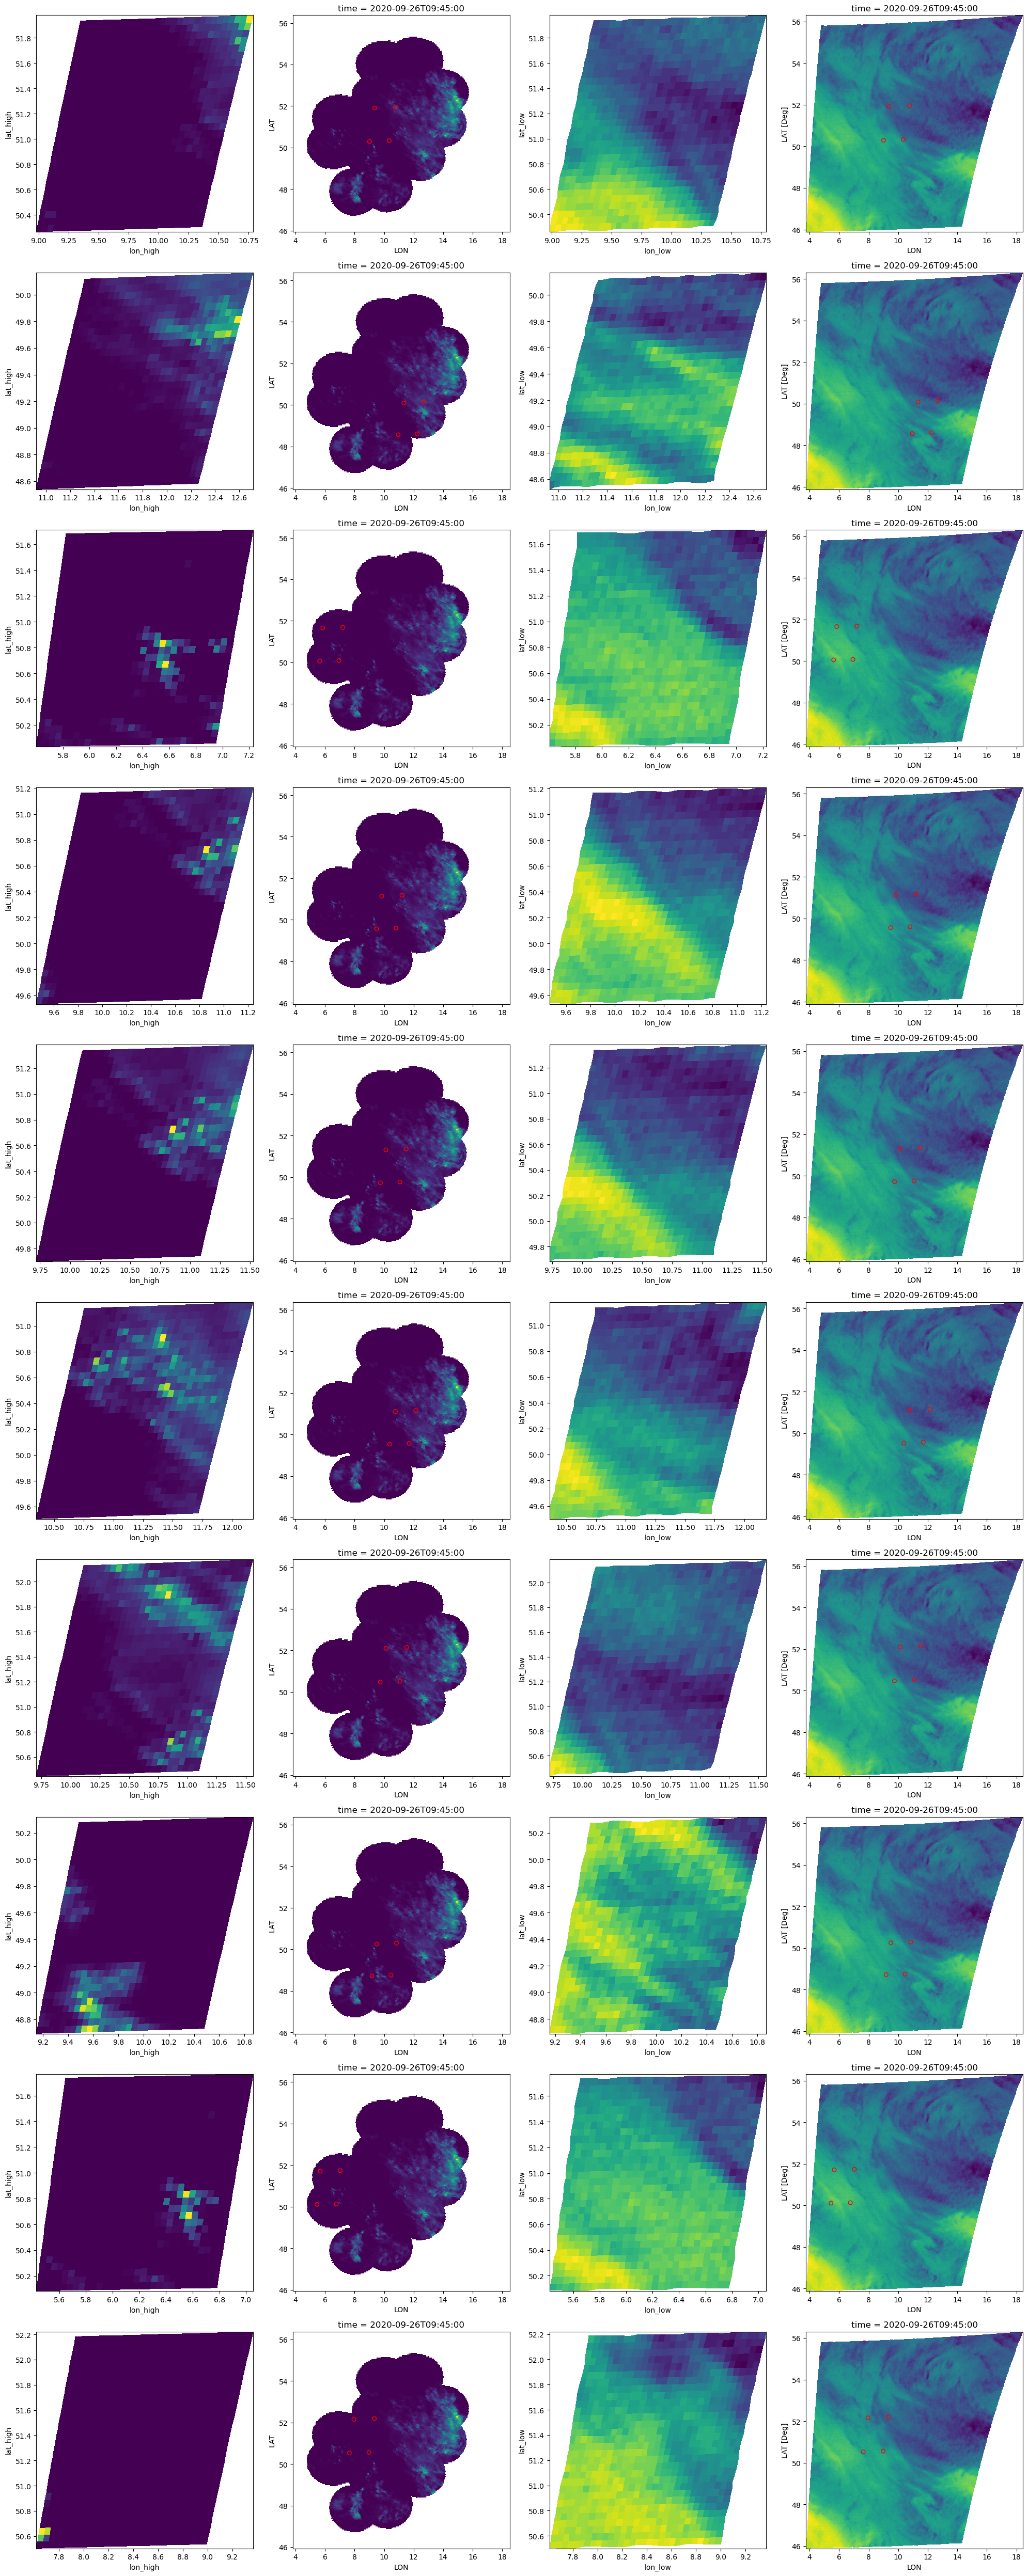

In [48]:
import matplotlib.colors as mpl_c
fig, ax = plt.subplots(nrows=10, ncols=4,figsize=(20,50))
for c in [ 1, 2, 3, 4]:
    for i in range(0,10):
        test.target.isel(ID=i).plot(x='lon_high', y='lat_high', ax=ax[i, 0], add_colorbar=False, label=None,
                                   #norm=mpl_c.LogNorm(vmin=0.00001, vmax=30)
                                   )
        im = ds_yw.rainfall_amount.isel(time=timestep).plot(x='LON', y='LAT', ax=ax[i,1], 
                                                                                                  #norm=mpl_c.LogNorm(vmin=0.00001, vmax=30),
                                                            add_colorbar=False, label=None)
        #test.target.isel(ID=i).plot(x='lon_high', y='lat_high', ax=ax[i, 2], add_colorbar=False, label=None, norm=mpl_c.LogNorm(vmin=0.00001, vmax=30))
        ax[i,1].scatter(x=test.isel(ID=i).lon_high.values[0, 0], y=test.isel(ID=i).lat_high.values[0,0], facecolors='none', edgecolors='r', s=30)
        ax[i,1].scatter(x=test.isel(ID=i).lon_high.values[len(test.y2)-1, len(test.y2)-1], y=test.isel(ID=i).lat_high.values[len(test.y2)-1, len(test.y2)-1], facecolors='none', edgecolors='r', s=30)
        ax[i,1].scatter(x=test.isel(ID=i).lon_high.values[0, len(test.y2)-1], y=test.isel(ID=i).lat_high.values[0,len(test.y2)-1], facecolors='none', edgecolors='r', s=30)
        ax[i,1].scatter(x=test.isel(ID=i).lon_high.values[len(test.y2)-1, 0], y=test.isel(ID=i).lat_high.values[len(test.y2)-1,0], facecolors='none', edgecolors='r', s=30)
        
        #channels
        test.input.isel(ID=i).isel(channels=6).plot(x='lon_low', y='lat_low', ax=ax[i, 2], add_colorbar=False, label=None)
        
        #
        ds_seviri.WV_062.isel(time=timestep).plot(x='LON', y='LAT', ax=ax[i,3], add_colorbar=False, label=None)
        #ax[i,4].scatter(x=test.isel(ID=i).lon_high.values[25,25], y=test.isel(ID=i).lat_high.values[25,25], facecolors='none', edgecolors='r', s=30)
        ax[i,3].scatter(x=test.isel(ID=i).lon_low.values[0, 0], y=test.isel(ID=i).lat_low.values[0,0], facecolors='none', edgecolors='r', s=30)
        ax[i,3].scatter(x=test.isel(ID=i).lon_low.values[len(test.y1)-1, len(test.y1)-1], y=test.isel(ID=i).lat_low.values[len(test.y1)-1, len(test.y1)-1], facecolors='none', edgecolors='r', s=30)
        ax[i,3].scatter(x=test.isel(ID=i).lon_low.values[0, len(test.y1)-1], y=test.isel(ID=i).lat_low.values[0,len(test.y1)-1], facecolors='none', edgecolors='r', s=30)
        ax[i,3].scatter(x=test.isel(ID=i).lon_low.values[len(test.y1)-1, 0], y=test.isel(ID=i).lat_low.values[len(test.y1)-1,0], facecolors='none', edgecolors='r', s=30)
        #test.input.isel(ID=i).isel(channels=6).plot( ax=ax[i, 5], add_colorbar=False, label=None)
        #ax[i, c-1].tick_params('both', labelleft=False, labelbottom=False)
        
        
#cbar = plt.colorbar(im, ax=ax[:2], orientation='horizontal', location='bottom')
plt.tight_layout()

### Create patches with parallelization

In [21]:
# Using dask parallelization
workers = 20

cluster = SLURMCluster(
    cores=32,                        # Total number of cores per job
    memory='64GB',                  # Total amount of memory per job
    processes=5,                    # Number of Python processes per job, moderate number 1/4 of cores
    local_directory='/tmp',  
    queue='ivyshort',
    project='CML',
    walltime='08:00:00'
)    
client = Client(cluster)

cluster.scale(workers)
client

/bg/fast/env_wiegels-r/mambaforge/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35106 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.27.80.110:35106/status,
Dashboard: http://172.27.80.110:35106/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.27.80.110:44374,Workers: 0
Dashboard: http://172.27.80.110:35106/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [20]:
cluster.close()
client.close()

In [24]:
%%time
# loop over time and use create patch function to create patches for whole time period
list_patches = []
for timestep in tqdm(range(0, ds_seviri.time.size)):
    list_patches.append(dask.delayed(create_patch_dataset)( ds_seviri, ds_yw, timestep))
patches_out = dask.compute(*list_patches)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 2070.85it/s]


CPU times: user 4min 33s, sys: 37.7 s, total: 5min 10s
Wall time: 14min 23s


In [25]:
print(len(patches_out))
patches_out_cleaned = [x for x in patches_out if ~np.isnan(x)]
print(len(patches_out_cleaned))
patches_out_cleaned[1]

972
972


<xarray.Dataset>
Dimensions:   (ID: 291, y1: 9, x1: 9, channels: 8, y2: 9, x2: 9, rainfall: 1,
               time: 1)
Coordinates:
    lat_low   (ID, y1, x1) float64 52.27 52.27 52.27 52.28 ... 48.91 48.91 48.91
    lon_low   (ID, y1, x1) float64 13.31 13.36 13.41 13.46 ... 12.11 12.15 12.2
    lat_high  (ID, y2, x2) float64 52.27 52.27 52.27 52.28 ... 48.91 48.91 48.91
    lon_high  (ID, y2, x2) float64 13.31 13.36 13.41 13.46 ... 12.11 12.15 12.2
Dimensions without coordinates: ID, y1, x1, channels, y2, x2, rainfall, time
Data variables:
    input     (ID, y1, x1, channels) float64 0.0 272.1 270.0 ... 0.0 234.1 246.2
    target    (ID, y2, x2, rainfall) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    times     (ID, time) datetime64[ns] 2020-10-21T21:30:00 ... 2020-10-21T21...

In [ ]:
ds_patches.to_netcdf("../data/patches.nc", encoding={'input': {'zlib': True}, 'target': {'zlib':True}})